### Notes
- **Before importing the data, the original Excel file was converted to a CSV UTF-8 (comma delimited) file.**
- **The following code is based in part on datacamp's "Human Resources Analytics: Predicting Employee Churn in Python" course. (https://app.datacamp.com/learn/courses/human-resources-analytics-predicting-employee-churn-in-python#!)**
- **The following code is based in part on *Machine Learning and Data Science Blueprints for Finance*.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('MBAselection.csv')

In [4]:
pd.set_option('max_columns', None)
data.head()

,SlNo,Gender,Gender-B,Percent_SSC,Board_SSC,Board_CBSE,Board_ICSE,Percent_HSC,Board_HSC,Stream_HSC,Percent_Degree,Course_Degree,Degree_Engg,Experience_Yrs,Entrance_Test,S-TEST,Percentile_ET,Percent_MBA,S-TEST*SCORE,Specialization_MBA,Marks_Communication,Marks_Projectwork,Marks_BOCA,Placement,Placement_B,Salary
0,1,M,0,62.00,Others,0,0,88.00,Others,Commerce,52.00,Science,0,0,MAT,1,55.0,58.80,55.0,Marketing & HR,50,65,74,Placed,1,270000
1,2,M,0,76.33,ICSE,0,1,75.33,Others,Science,75.48,Computer Applications,0,1,MAT,1,86.5,66.28,86.5,Marketing & Finance,69,70,75,Placed,1,200000
2,3,M,0,72.00,Others,0,0,78.00,Others,Commerce,66.63,Engineering,1,0,NaN,0,0.0,52.91,0.0,Marketing & Finance,50,61,59,Placed,1,240000
3,4,M,0,60.00,CBSE,1,0,63.00,CBSE,Arts,58.00,Management,0,0,MAT,1,75.0,57.80,75.0,Marketing & Finance,54,66,62,Placed,1,250000
4,5,M,0,61.00,CBSE,1,0,55.00,ISC,Science,54.00,Engineering,1,1,MAT,1,66.0,59.43,66.0,Marketing & HR,52,65,67,Placed,1,180000


In [5]:
print(data.shape)

(391, 26)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SlNo                 391 non-null    int64  
 1   Gender               391 non-null    object 
 2   Gender-B             391 non-null    int64  
 3   Percent_SSC          391 non-null    float64
 4   Board_SSC            391 non-null    object 
 5   Board_CBSE           391 non-null    int64  
 6   Board_ICSE           391 non-null    int64  
 7   Percent_HSC          391 non-null    float64
 8   Board_HSC            391 non-null    object 
 9   Stream_HSC           391 non-null    object 
 10  Percent_Degree       391 non-null    float64
 11  Course_Degree        391 non-null    object 
 12  Degree_Engg          391 non-null    int64  
 13  Experience_Yrs       391 non-null    int64  
 14  Entrance_Test        324 non-null    object 
 15  S-TEST               391 non-null    int

**We have 26 columns and almost 391 entries, which means the DataFrame includes data on almost 400 employees about 26 different variables.**

### Descriptive statistics (before transforming categorical variables (into numerical))
- **Placement rate**
- **Histograms**
- **Correlations**

(**Remove the #s and you will get results.**)

Placed        312
Not Placed     79
Name: Placement, dtype: int64
Placed        79.795396
Not Placed    20.204604
Name: Placement, dtype: float64


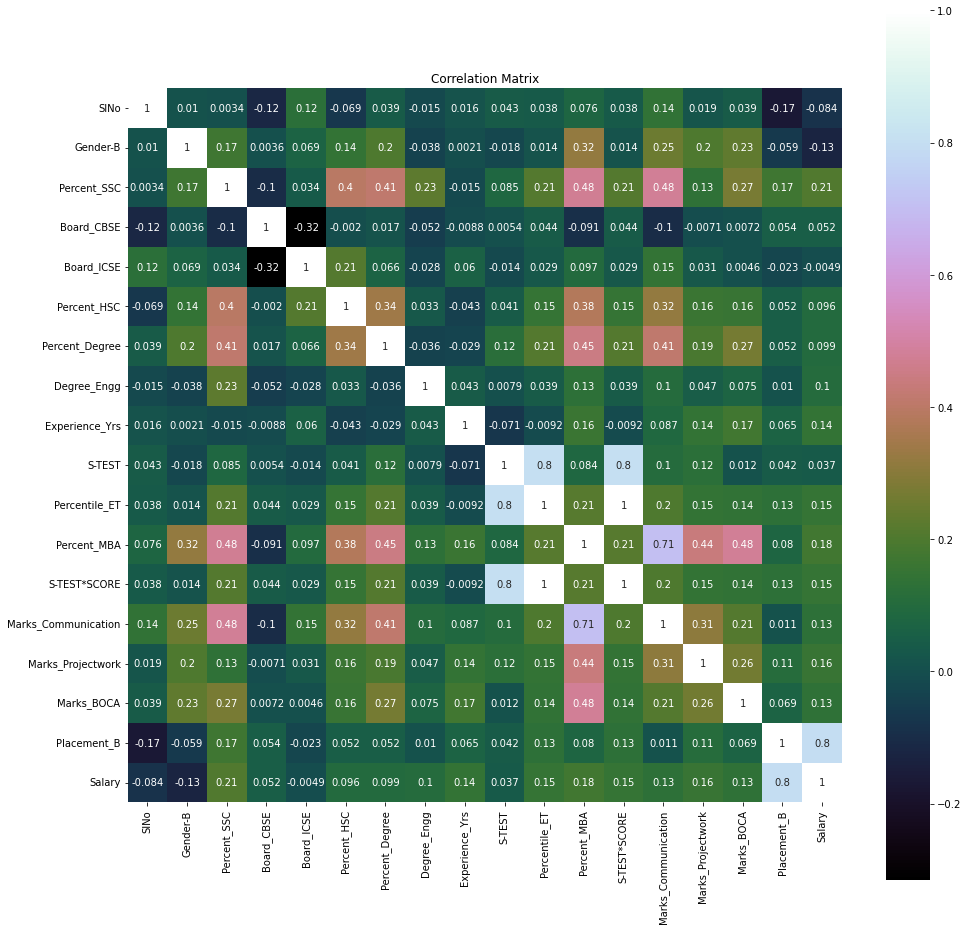

In [7]:
# Placement rate
n_employees = len(data)
print(data.Placement.value_counts())
print(data.Placement.value_counts()/n_employees*100)

# Histograms
#data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12)) # bins=50
#plt.show()

# Correlations
corr_matrix = data.corr()
plt.figure(figsize=(16,16))
plt.title('Correlation Matrix')
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.show()

**Approximately 80% of the students were placed and 20% were not.**

### Transforming categorical variables (into numerical)
- **Ordinal - variables with two or more categories that can be ranked or ordered**
- **Nominal - variables with two or more categories with do not have an intrinsic order**

**"When dealing with dummy variables one should be cautious of a phenomenon known as dummy trap. ... Whenever ... dummies are created one of them can be dropped as its information is already included in others."**<br>

**(cf. datacamp)**

In [8]:
print(data.Gender.unique())
print(data.Board_SSC.unique())
print(data.Board_HSC.unique())
print(data.Stream_HSC.unique())
print(data.Course_Degree.unique())
print(data.Entrance_Test.unique())
print(data.Specialization_MBA.unique())
print(data.Placement.unique())

['M' 'F']
['Others' 'ICSE' 'CBSE']
['Others' 'CBSE' 'ISC']
['Commerce' 'Science' 'Arts']
['Science' 'Computer Applications' 'Engineering' 'Management' 'Commerce'
 'Others' 'Arts']
['MAT' nan 'K-MAT' 'CAT' 'PGCET' 'GCET' 'G-MAT' 'XAT' 'G-SAT']
['Marketing & HR' 'Marketing & Finance' 'Marketing & IB']
['Placed' 'Not Placed']


In [9]:
# Getting dummies

# 0. Change all duplicate column names to unique names
data_dummy = data

data_dummy["Gender"] = data_dummy["Gender"].replace({"F":"Gender_F", "M":"Gender_M"})
data_dummy["Board_SSC"] = data_dummy["Board_SSC"].replace({"CBSE":"Board_SSC_CBSE", 
                                               "ICSE":"Board_SSC_ICSE", 
                                               "Others":"Board_SSC_Others"})
data_dummy["Board_HSC"] = data_dummy["Board_HSC"].replace({"CBSE":"Board_HSC_CBSE", 
                                               "ISC":"Board_HSC_ISC", 
                                               "Others":"Board_HSC_Others"})
data_dummy["Stream_HSC"] = data_dummy["Stream_HSC"].replace({"Arts":"Stream_HSC_Arts", 
                                                 "Commerce":"Stream_HSC_Commerce", 
                                                 "Science":"Stream_HSC_Science"})
data_dummy["Course_Degree"] = data_dummy["Course_Degree"].replace({"Arts":"Course_Degree_Arts", 
                                                       "Commerce":"Course_Degree_Commerce", 
                                                       "Computer Applications":"Course_Degree_Computer Applications", 
                                                       "Engineering":"Course_Degree_Engineering", 
                                                       "Management":"Course_Degree_Management", 
                                                       "Others":"Course_Degree_Others", 
                                                       "Science":"Course_Degree_Science"})
data_dummy["Entrance_Test"] = data_dummy["Entrance_Test"].replace({"CAT":"Entrance_Test_CAT", "G-MAT":"Entrance_Test_G-MAT", 
                                                       "G-SAT":"Entrance_Test_G-SAT", "GCET":"Entrance_Test_GCET", 
                                                       "K-MAT":"Entrance_Test_K-MAT", "MAT":"Entrance_Test_MAT", 
                                                       "PGCET":"Entrance_Test_PGCET", "XAT":"Entrance_Test_XAT"})
data_dummy["Specialization_MBA"] = data_dummy["Specialization_MBA"].replace({"Marketing & Finance"
                                                                 :"Specialization_MBA_Marketing & Finance", 
                                                                 "Marketing & HR":"Specialization_MBA_Marketing & HR", 
                                                                 "Marketing & IB":"Specialization_MBA_Marketing & IB"})
data_dummy["Placement"] = data_dummy["Placement"].replace({"Not Placed":"Placement_Not Placed", "Placed":"Placement_Placed"})

# 1. Get dummies and save them inside a new DataFrame
Genders = pd.get_dummies(data_dummy.Gender)
Board_SSCs = pd.get_dummies(data_dummy.Board_SSC)
Board_HSCs = pd.get_dummies(data_dummy.Board_HSC)
Stream_HSCs = pd.get_dummies(data_dummy.Stream_HSC)
Course_Degrees = pd.get_dummies(data_dummy.Course_Degree)
Entrance_Tests = pd.get_dummies(data_dummy.Entrance_Test)
Specialization_MBAs = pd.get_dummies(data_dummy.Specialization_MBA)
Placements = pd.get_dummies(data_dummy.Placement)

# 2. Take a quick look to the first 5 rows of each new DataFrame
#print(Genders.head(5))
#print(Board_SSCs.head(5))
#print(Board_HSCs.head(5))
#print(Stream_HSCs.head(5))
#print(Course_Degrees.head(5))
#print(Entrance_Tests.head(5))
#print(Specialization_MBAs.head(5))
#print(Placements.head(5))

In [10]:
# Dummy trap

# 1. Drop one of the columns to avoid dummy trap
Genders = Genders.drop("Gender_M", axis=1)
Board_SSCs = Board_SSCs.drop("Board_SSC_Others", axis=1)
Board_HSCs = Board_HSCs.drop("Board_HSC_Others", axis=1)
Stream_HSCs = Stream_HSCs.drop("Stream_HSC_Science", axis=1)
Course_Degrees = Course_Degrees.drop("Course_Degree_Others", axis=1)
Entrance_Tests = Entrance_Tests.drop("Entrance_Test_XAT", axis=1)
Specialization_MBAs = Specialization_MBAs.drop("Specialization_MBA_Marketing & IB", axis=1)
Placements = Placements.drop("Placement_Not Placed", axis=1)

# 2. Drop the old columns as you don't need it anymore
data_dummy = data_dummy.drop("Gender", axis=1)
data_dummy = data_dummy.drop("Board_SSC", axis=1)
data_dummy = data_dummy.drop("Board_HSC", axis=1)
data_dummy = data_dummy.drop("Stream_HSC", axis=1)
data_dummy = data_dummy.drop("Course_Degree", axis=1)
data_dummy = data_dummy.drop("Entrance_Test", axis=1)
data_dummy = data_dummy.drop("Specialization_MBA", axis=1)
data_dummy = data_dummy.drop("Placement", axis=1)

# 3. Join the new DataFrames to your dataset: done
data_dummy = data_dummy.join(Genders)
data_dummy = data_dummy.join(Board_SSCs)
data_dummy = data_dummy.join(Board_HSCs)
data_dummy = data_dummy.join(Stream_HSCs)
data_dummy = data_dummy.join(Course_Degrees)
data_dummy = data_dummy.join(Entrance_Tests)
data_dummy = data_dummy.join(Specialization_MBAs)
data_dummy = data_dummy.join(Placements)

In [11]:
# Replace spaces in column names with "_"
data_dummy.columns = data_dummy.columns.str.replace(" ", "_")
data_dummy.head()

,SlNo,Gender-B,Percent_SSC,Board_CBSE,Board_ICSE,Percent_HSC,Percent_Degree,Degree_Engg,Experience_Yrs,S-TEST,Percentile_ET,Percent_MBA,S-TEST*SCORE,Marks_Communication,Marks_Projectwork,Marks_BOCA,Placement_B,Salary,Gender_F,Board_SSC_CBSE,Board_SSC_ICSE,Board_HSC_CBSE,Board_HSC_ISC,Stream_HSC_Arts,Stream_HSC_Commerce,Course_Degree_Arts,Course_Degree_Commerce,Course_Degree_Computer_Applications,Course_Degree_Engineering,Course_Degree_Management,Course_Degree_Science,Entrance_Test_CAT,Entrance_Test_G-MAT,Entrance_Test_G-SAT,Entrance_Test_GCET,Entrance_Test_K-MAT,Entrance_Test_MAT,Entrance_Test_PGCET,Specialization_MBA_Marketing_&_Finance,Specialization_MBA_Marketing_&_HR,Placement_Placed
0,1,0,62.00,0,0,88.00,52.00,0,0,1,55.0,58.80,55.0,50,65,74,1,270000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1
1,2,0,76.33,0,1,75.33,75.48,0,1,1,86.5,66.28,86.5,69,70,75,1,200000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1
2,3,0,72.00,0,0,78.00,66.63,1,0,0,0.0,52.91,0.0,50,61,59,1,240000,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
3,4,0,60.00,1,0,63.00,58.00,0,0,1,75.0,57.80,75.0,54,66,62,1,250000,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1
4,5,0,61.00,1,0,55.00,54.00,1,1,1,66.0,59.43,66.0,52,65,67,1,180000,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1


In [12]:
print(data_dummy.shape)

(391, 41)


In [13]:
data_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 41 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   SlNo                                    391 non-null    int64  
 1   Gender-B                                391 non-null    int64  
 2   Percent_SSC                             391 non-null    float64
 3   Board_CBSE                              391 non-null    int64  
 4   Board_ICSE                              391 non-null    int64  
 5   Percent_HSC                             391 non-null    float64
 6   Percent_Degree                          391 non-null    float64
 7   Degree_Engg                             391 non-null    int64  
 8   Experience_Yrs                          391 non-null    int64  
 9   S-TEST                                  391 non-null    int64  
 10  Percentile_ET                           391 non-null    float6

**Now, we have 41 columns and almost 391 entries, which means the DataFrame includes data on almost 400 employees about 41 different variables.**

### Descriptive statistics (dummy variable version)
- **Placement rate**
- **Histograms**
- **Correlations**

(**Remove the #s and you will get results.**)

1    312
0     79
Name: Placement_Placed, dtype: int64
1    79.795396
0    20.204604
Name: Placement_Placed, dtype: float64


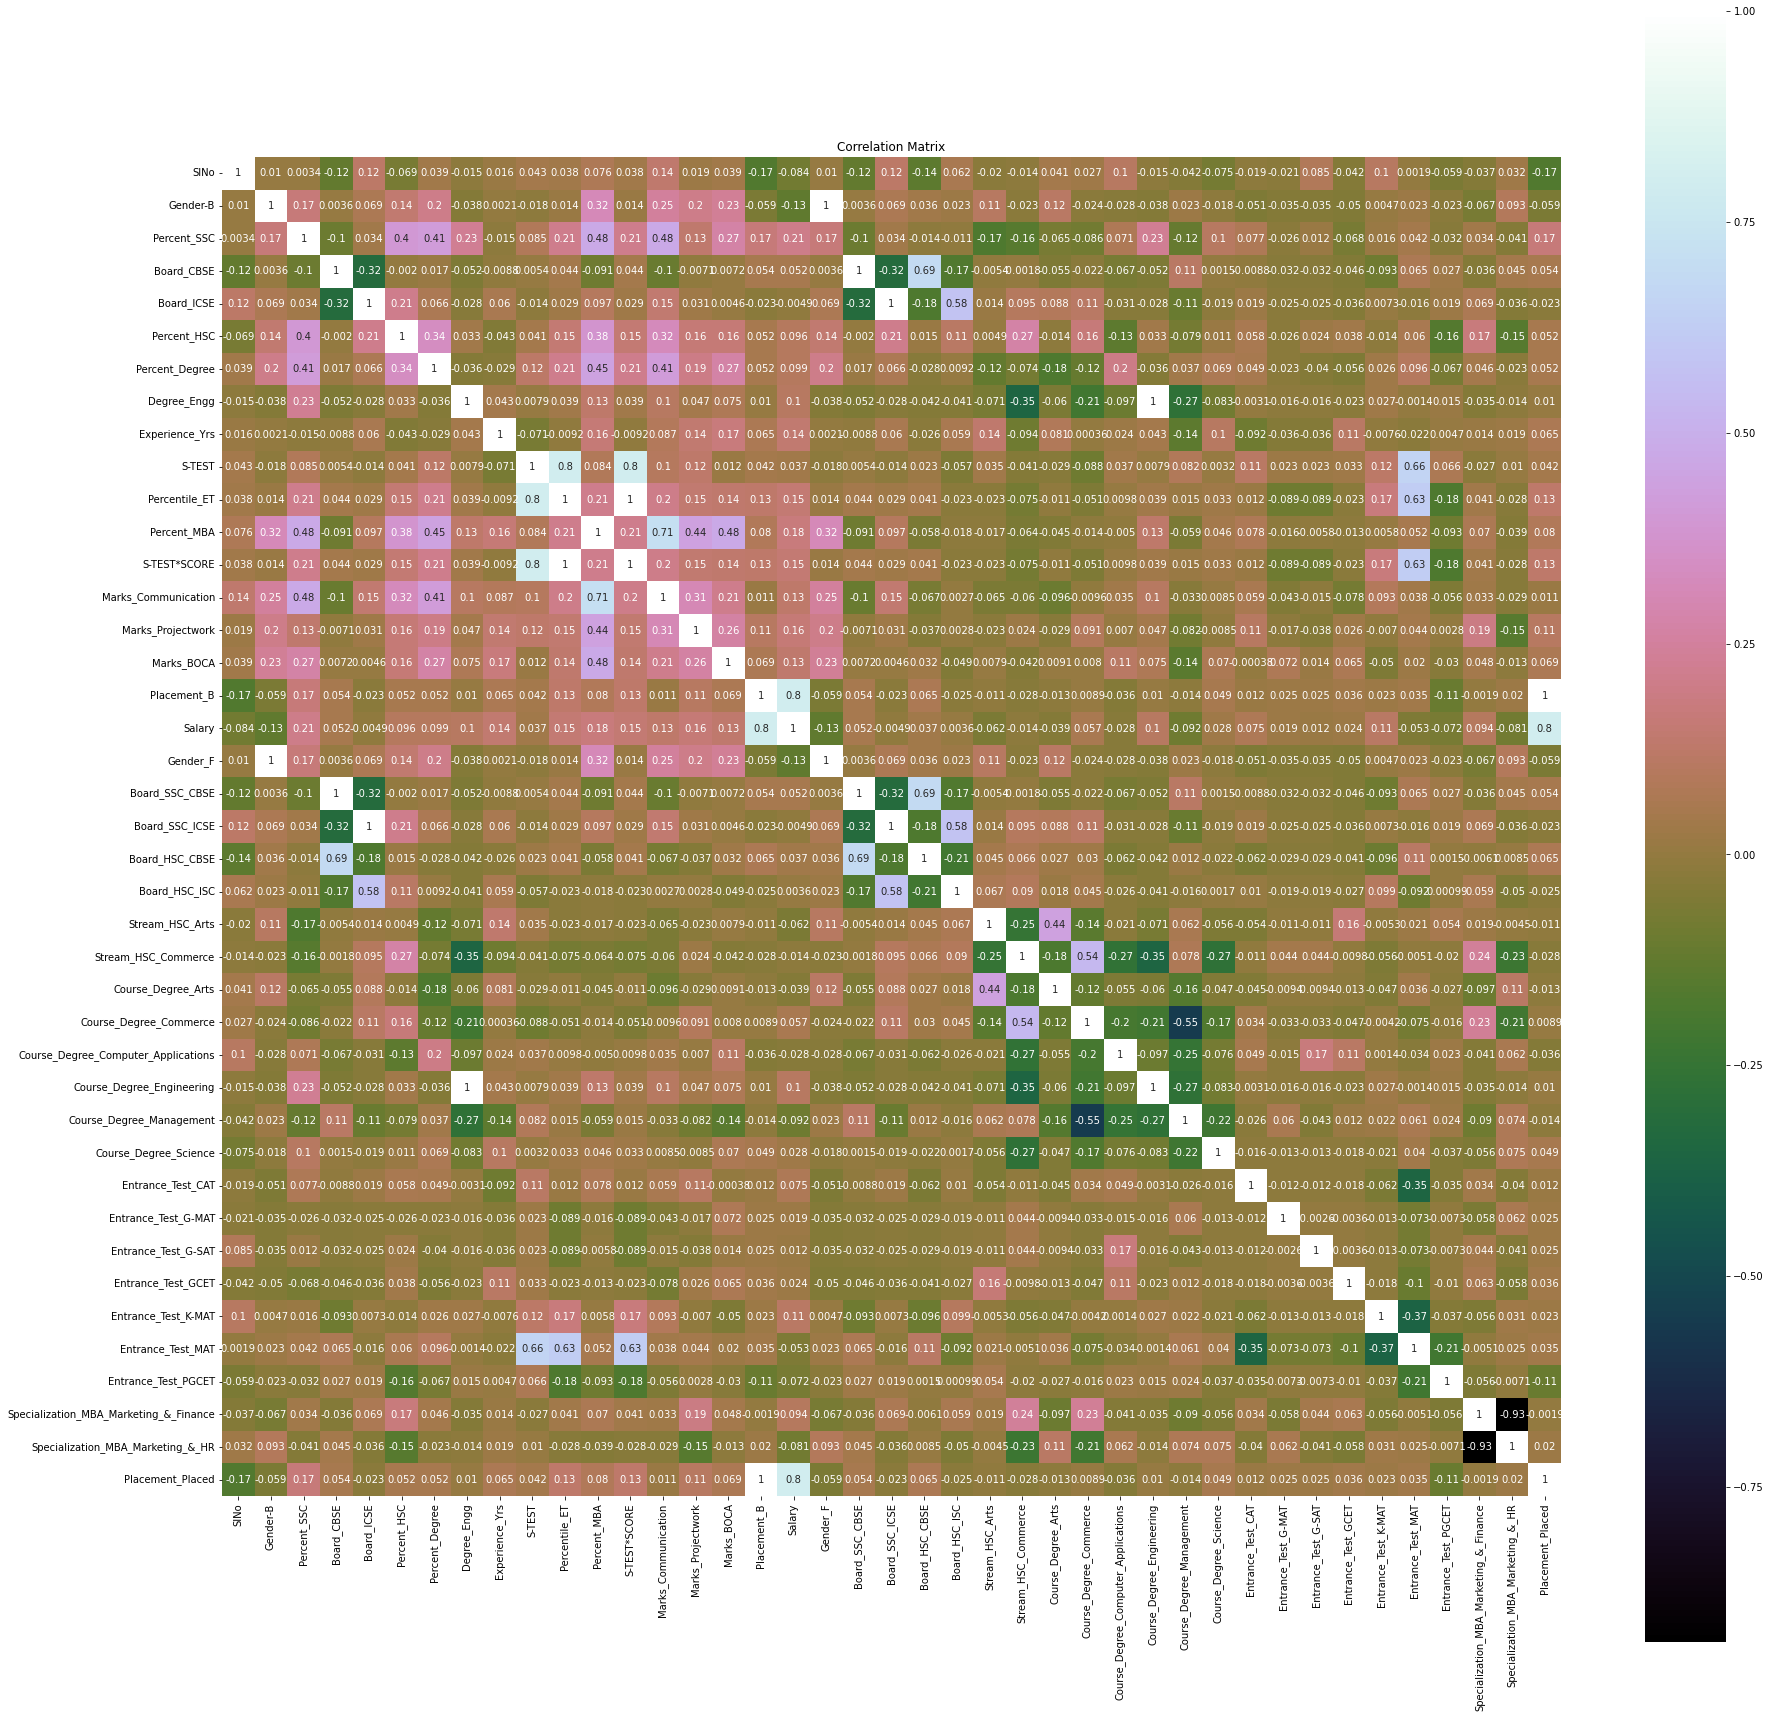

In [14]:
# Placement rate
n_employees = len(data_dummy)
print(data_dummy.Placement_Placed.value_counts())
print(data_dummy.Placement_Placed.value_counts()/n_employees*100)

# Histograms
#data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12)) # bins=50
#plt.show()

# Correlations
corr_matrix = data_dummy.corr()
plt.figure(figsize=(30,30))
plt.title('Correlation Matrix')
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.show()

**As we have seen before, approximately 80% of the students were placed and 20% were not.**

# Now we have two datasets:
 - **data - the original data**
 - **data_dummy - data converted from categorical Carna variables to numbers**

# Let's do a classification analysis with dummy_data.

### Splitting the Data
- **target = placement (Y)**
- **features = everything else (X)**
<br>

- **train - the component used to develop the model**
- **test - the component used to validate the model**

**In this analysis, 75% of the dataset will be used for modeling and 25% for testing.**

In [15]:
# Set the target and features
# Choose the dependent variable column "Placement" and set it as target
target = data_dummy.Placement_Placed
# Drop column churn and set everything else as features
features = data_dummy.drop("Placement_Placed",axis=1)

# Import the function for splitting dataset into train and test
from sklearn.model_selection import train_test_split

# Use that function to create the splits both for target and for features
# Set the test sample to be 25% of your observations
Y_train, Y_test, X_train, X_test = train_test_split(target,features,test_size=0.25, random_state=42) # random_state=42

### Compare models and algorithms
- **Models**
- **K-fold cross validation**

#### Models

In [16]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# Neural Network
models.append(('NN', MLPClassifier()))
# Ensemble Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))
models.append(('ET', ExtraTreesClassifier()))

#### K-folds cross validation

- accuracy - see how correct the prediction was
- precision - see how correct you were in what you predicted to be positive
- recall - see how many of those that were actually positive could be predicted to be positive

The scoring parameter: defining model evaluation rules: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [17]:
# K-folds cross validation
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# Test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 1.000000 (0.000000)
LDA: 0.989770 (0.021956)
KNN: 1.000000 (0.000000)
CART: 1.000000 (0.000000)
NB: 1.000000 (0.000000)
NN: 1.000000 (0.000000)
AB: 1.000000 (0.000000)
GBM: 1.000000 (0.000000)
RF: 1.000000 (0.000000)
ET: 1.000000 (0.000000)


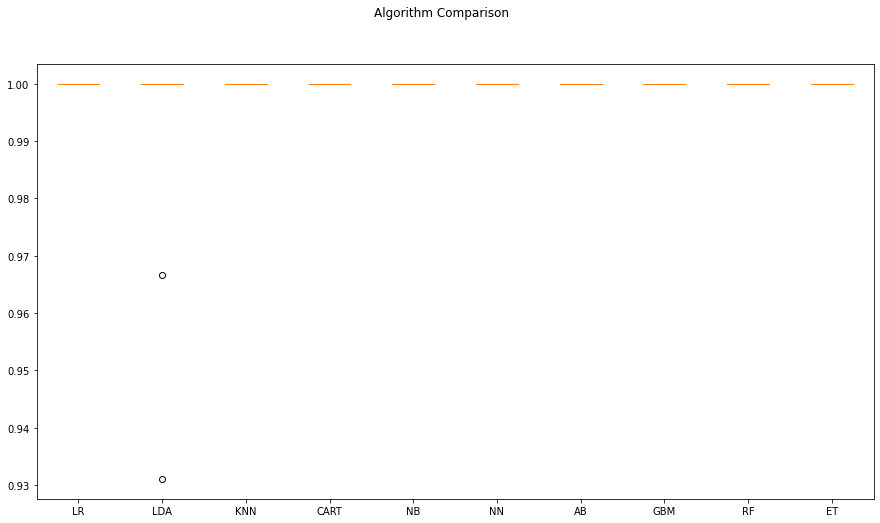

In [18]:
# Compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

**The code doesn't seem to be working well, so I'm going to try logistic regression for now.**

### Logistic Regression

In [19]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [20]:
predictions = model.predict(X_test)
print(classification_report(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        79

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

[[19  0]
 [ 0 79]]


**The code doesn't seem to be working well. I have done the process to deal with the so-called dummy trap. For example, in the gender variable, after converting it to the dummy variable, I dropped M from the dataset, leaving the F. Still, maybe we should remove some dummy variables because things like multicollinearity are happening.**

### Reinforcement Learning
**One possible way to do this is to predict the top three highest paid graduates.**